In [1]:
!source .env
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch 
from hidden import *

data = pd.read_csv('liar_dataset/data_with_responses_and_certainty.tsv', sep='\t')
data.head()


/bin/bash: line 1: .env: No such file or directory


,id,label,statement,subject,speaker,job,state,party,barely_true,false,half_true,mostly_true,pants_on_fire,venue,full_response,substring_after_assistant,certainty_score
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,"user\n\nGiven a statement, predict if is true ...",False.\n\nThe statement is false because Ann &...,4.956542
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"user\n\nGiven a statement, predict if is true ...",False.\n\nThe statement is false because the d...,4.957538
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,"user\n\nGiven a statement, predict if is true ...",False.\n\nHillary Clinton did not vote to give...,4.970032
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,"user\n\nGiven a statement, predict if is true ...",False.\n\nThe statement is false because there...,4.950550
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"user\n\nGiven a statement, predict if is true ...",False.\n\nThe statement is false because it is...,4.471705


In [2]:
data.certainty_score.describe()

count    12791.000000
mean         4.900066
std          0.163623
min          3.666179
25%          4.928520
50%          4.945042
75%          4.959691
max          5.166005
Name: certainty_score, dtype: float64

In [3]:
# normalize the certainty_score column using sigmoid function
data['certainty_score_soft'] = 1/(1+np.exp(-data.certainty_score))
data.certainty_score_soft.describe()

# using the median as the threshold for the certainty score
threshold = data.certainty_score_soft.median()
data['certainty'] = data.certainty_score_soft > threshold
data.head()

# remove certainty_score_soft and certainty_score columns
data = data.drop(columns=['certainty_score_soft', 'certainty_score'])

In [4]:
input_prompts = data.full_response.to_numpy()

In [5]:
input_prompts

array(['user\n\nGiven a statement, predict if is true or fake. Give your classification label as True or False followed by a period.\nAfter that, provide an explanation for your classification in one sentence followed by a period. For instance, "True. The statement is true because it is backed by scientific evidence."\nHere is the statement:\nSays the Annies List political group supports third-trimester abortions on demand.assistant\n\nFalse.\n\nThe statement is false because Ann & Associates, also known as the Annies List, is a political action committee that supports pro-choice policies, but it does not specifically advocate for third-trimester abortions on demand, and most medical organizations and laws restrict late-term abortions to cases where the mother\'s life or health is at risk.',
       'user\n\nGiven a statement, predict if is true or fake. Give your classification label as True or False followed by a period.\nAfter that, provide an explanation for your classification in o

In [6]:
# load the model
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
model, tokenizer = load_model(model_id)
reps = get_batch_hidden_representations(model, tokenizer, list(input_prompts), batch_size=8)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [8]:
reps.shape

(12791, 4096)

In [9]:
data['hidden_representations'] = list(reps)

In [10]:
data.hidden_representations

0        [0.14648438, -0.30859375, 0.94921875, -0.32226...
1        [0.015991211, -0.38867188, 0.84765625, -0.1464...
2        [-0.063964844, -0.203125, 0.74609375, -0.03833...
3        [-0.0154418945, 0.11669922, 0.890625, 0.021484...
4        [-0.0030822754, 0.037841797, 0.78515625, -0.00...
                               ...                        
12786    [-0.067871094, -0.26171875, 0.93359375, -0.053...
12787    [0.13085938, 0.16015625, 0.78515625, -0.201171...
12788    [0.16894531, -0.23632812, 0.7421875, -0.15625,...
12789    [0.114746094, -0.14550781, 0.8984375, -0.08251...
12790    [-0.09277344, -0.25585938, 0.87890625, -0.0235...
Name: hidden_representations, Length: 12791, dtype: object

In [11]:
# PCA on reps to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(reps)
reps_2d = pca.transform(reps)

data['hidden_representations_2d'] = list(reps_2d)

In [12]:
data.hidden_representations_2d

0         [-5.7756987, -2.594647]
1         [-3.812398, -5.2766294]
2        [-4.255292, -0.62904835]
3         [-4.6082964, 5.9457984]
4           [-4.009057, 5.213971]
                   ...           
12786     [-4.2584505, -1.870076]
12787      [-3.5077085, 6.019176]
12788     [-3.1520395, -6.939423]
12789    [-5.1383314, -0.5331623]
12790      [-3.804513, 1.4609423]
Name: hidden_representations_2d, Length: 12791, dtype: object

Plotting the clusters

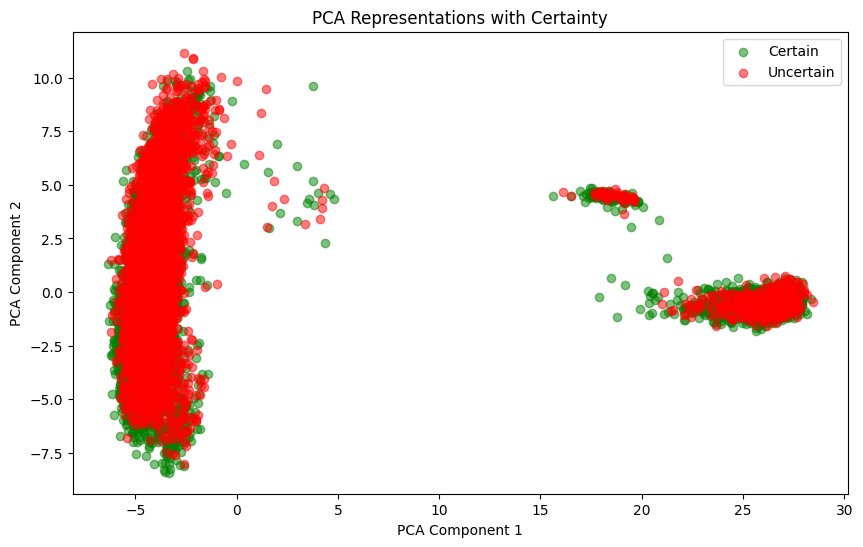

In [14]:
import matplotlib.pyplot as plt

# Separate the PCA'd vectors based on the 'certainty' status
certain_points = np.array(data[data['certainty'] == True]['hidden_representations_2d'].tolist())
uncertain_points = np.array(data[data['certainty'] == False]['hidden_representations_2d'].tolist())

# Plotting
plt.figure(figsize=(10, 6))

# Plot certain points in green
plt.scatter(certain_points[:, 0], certain_points[:, 1], color='green', label='Certain', alpha=0.5)

# Plot uncertain points in red
plt.scatter(uncertain_points[:, 0], uncertain_points[:, 1], color='red', label='Uncertain', alpha=0.5)

plt.title('PCA Representations with Certainty')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

subsample red points

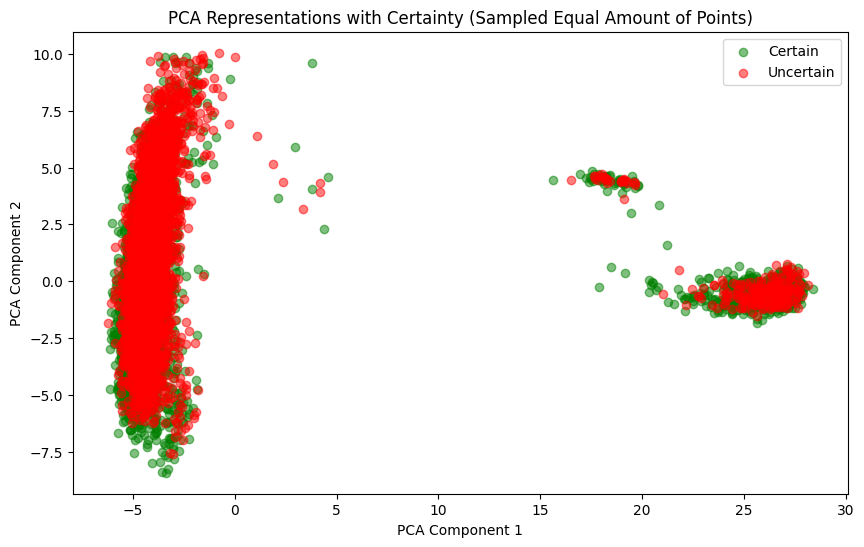

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame

# Set the fraction of points to sample for both certain and uncertain points
fraction_to_sample = 0.5  # Adjust this fraction as needed

# Calculate the number of points to sample for both certain and uncertain points
num_certain_points = int(len(data[data['certainty'] == True]) * fraction_to_sample)
num_uncertain_points = int(len(data[data['certainty'] == False]) * fraction_to_sample)

# Ensure that the number of sampled points does not exceed the smaller group
num_points_to_sample = min(num_certain_points, num_uncertain_points)

# Sample points based on the calculated number
sampled_certain_points = data[data['certainty'] == True].sample(n=num_points_to_sample)
sampled_uncertain_points = data[data['certainty'] == False].sample(n=num_points_to_sample)

# Convert sampled points to numpy arrays
certain_points = np.array(sampled_certain_points['hidden_representations_2d'].tolist())
uncertain_points = np.array(sampled_uncertain_points['hidden_representations_2d'].tolist())

# Plotting
plt.figure(figsize=(10, 6))

# Plot sampled certain points in green
plt.scatter(certain_points[:, 0], certain_points[:, 1], color='green', label='Certain', alpha=0.5)

# Plot sampled uncertain points in red
plt.scatter(uncertain_points[:, 0], uncertain_points[:, 1], color='red', label='Uncertain', alpha=0.5)

plt.title('PCA Representations with Certainty (Sampled Equal Amount of Points)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()